SIR Pyro Object with U value included

In [31]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [32]:
class SimpleSIRModel(CompartmentalModel):
    def __init__(self, population, recovery_time, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time
        self.data = data
        
    def global_model(self):
        """
        samples global parameters and packs them into a single return value (here a tuple, but any structure is allowed). 
        The return value is available as the params argument to the other two methods.
        """
        tau = self.recovery_time
        u = pyro.sample("u", dist.Uniform(0, 0.85))
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau, rho, u

    def initialize(self, params):
        """
        samples (or deterministically sets) initial values of time series,
        returning a dictionary mapping time series name to initial value.
        """
        # Start with a single infection.
        return {"S": self.population - 1, "I": 1}

    def transition(self, params, state, t):
        """
        inputs global params, the state at the previous time step, and the time index t (which may be a slice!). 
        It then samples flows and updates the state dict.
        """
        R0, tau, rho, u = params # R0 

        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t),
                          infection_dist(individual_rate=(1 - u) * R0 / tau,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau))

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2I, rho),
                    obs=self.data[t] if t_is_observed else None)

# Assessing the impact of u parameter

In [40]:
population = 10000
recovery_time = 7.
duration = 100
empty_data = [None] * duration

model = SimpleSIRModel(population, recovery_time, empty_data)


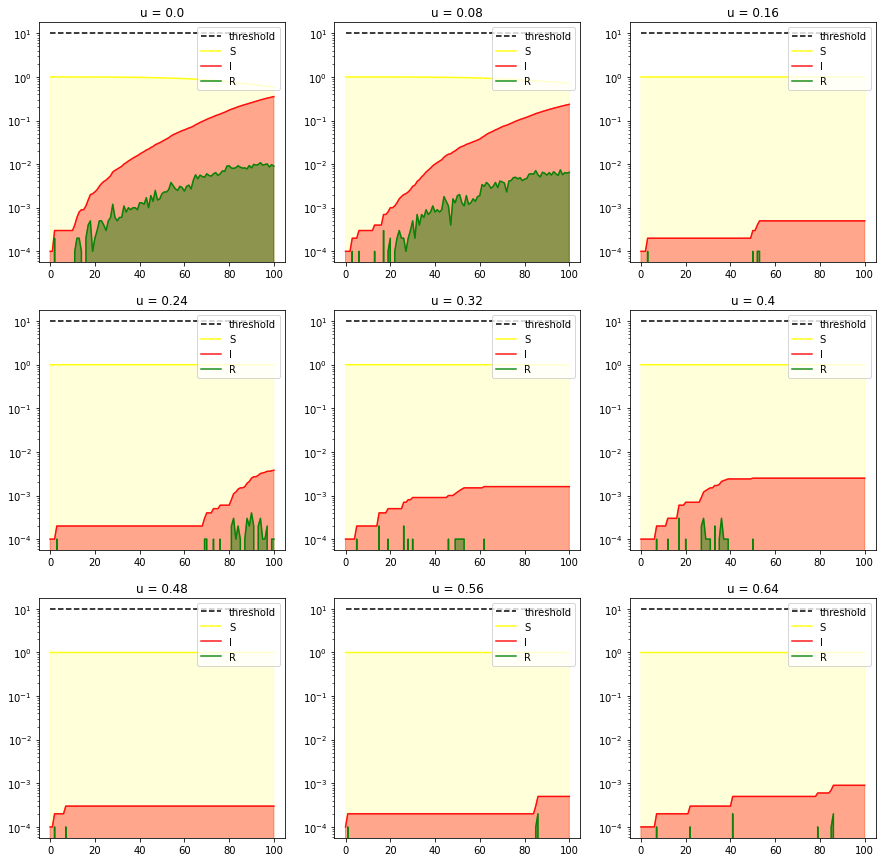

In [41]:
import numpy as np
np.random.seed(1234)
fig, ax = plt.subplots(3,3, figsize=(15,15))
dummyu = np.arange(0, 0.8, 0.08)
count = 0
for ii in range(3):   # since i is used for the compartmental model
    for j in range(3):
        u = dummyu[count]


        torch.manual_seed(1234)
        pyro.set_rng_seed(1234)
        
        
        data = model.generate({"R0": 1.5,'u':u})
        for attempt in range(100):
            data = model.generate({"R0": 1.5,'u':u})
            total_infections = data["S2I"].sum().item()
            if 4000 <= total_infections <= 6000:
                break
        #print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))

        _S = [population]
        _I = [1]
        _R = [0]

        for t in range(duration):
            s = _S[t] - data['S2I'][t]
            i = _I[t] + data['I2R'][t]
            r = data['I2R'][t]
            _S.append(s)
            _I.append(i)
            _R.append(r)
            
        _S = torch.tensor(_S)/population
        _I = torch.tensor(_I)/population
        _R = torch.tensor(_R)/population
        x_vals = np.arange(0, len(_S), 1)  # length of all arrays is the same as duration
        
        ax[ii, j].set_yscale('log')        
        ax[ii, j].plot([population/1000]*len(_S), label='threshold', color='black', linestyle='dashed')
        ax[ii, j].plot(_S, label='S', color='yellow', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _S, color='yellow', alpha=0.15)
        ax[ii, j].plot(_I, label='I', color='red', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _I, color='red', alpha=0.35)
        ax[ii, j].plot(_R, label='R', color='green', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _R, color='green', alpha=0.45)
        ax[ii, j].legend(loc="upper right")
        ax[ii, j].set_title("u = {}".format(u))
        count += 1